<a href="https://colab.research.google.com/github/moksh-ahuja/land-use-rl-project/blob/main/RL_Land_Use_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy matplotlib pandas gym

In [2]:
!pip install stable-baselines3[extra] optuna --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Setting up RL Environment

In [37]:
import gymnasium as gym
import numpy as np
import pandas as pd
from gymnasium import spaces

class LandUseOptimizationEnv(gym.Env):
    def __init__(self, df, region_list, forecast_years=25):
        super().__init__()
        self.data = df.copy()
        self.regions = region_list
        self.forecast_years = forecast_years

        self.year_index = 0
        self.years = sorted(self.data['year'].unique())
        self.current_year = self.years[self.year_index]
        self.end_year = self.years[min(self.forecast_years, len(self.years) - 1)]
        self.num_regions = len(self.regions)
        self.region = self.regions[0]
        self.total_land = 100_000

        self.target_forest_share = 0.33
        self.env_degradation = 0.0

        self.forest_history = []
        self.co2_history = []

        self.action_space = spaces.Box(low=np.array([0.0, 0.0, 0.0]), high=np.array([1.0, 1.0, 1.0]), dtype=np.float32)
        self.observation_space = spaces.Box(low=-5.0, high=5.0, shape=(11,), dtype=np.float32)
        self.previous_allocation = np.array([0.48, 0.33, 0.19], dtype=np.float32)

    def step(self, action):
        action = np.clip(action, 0, 1)
        if np.sum(action) == 0:
            action = np.array([0.48, 0.33, 0.19], dtype=np.float32)
        else:
            action = action / np.sum(action)

        agri_share, forest_share, solar_share = action

        row = self.data[(self.data['year'] == self.current_year) & (self.data['region'] == self.region)].iloc[0]
        food_production = agri_share * row['agri_yield'] * row['total_land']
        food_required = max(row['population'] * 0.35, 1e-8)
        food_gap = food_production - food_required
        food_ratio = food_production / food_required

        solar_energy = solar_share * row['solar_efficiency'] * row['total_land']
        forest_co2 = forest_share * row['co2_per_forest_km2'] * row['total_land'] * (1 - self.env_degradation)
        solar_co2 = solar_energy * row['carbon_price']
        co2_reduction = forest_co2 + solar_co2

        agri_revenue = food_production * row['energy_price']
        solar_cost = solar_share * row['solar_install_cost']
        net_revenue = agri_revenue - solar_cost

        export_revenue = 0.0
        export_carbon_cost = 0.0
        if food_gap > 0:
            export_revenue = food_gap * row['energy_price'] * 0.5
            export_carbon_cost = food_gap * 0.1

        co2_reduction -= export_carbon_cost

        if forest_share < self.target_forest_share:
            self.env_degradation = min(1.0, self.env_degradation + 0.15 * (self.target_forest_share - forest_share))
        else:
            self.env_degradation = max(0.0, self.env_degradation - 0.05)

        self.forest_history.append(forest_share)
        if len(self.forest_history) > 3:
            self.forest_history.pop(0)

        scaled_co2_reduction = co2_reduction / 1e8
        if not np.isfinite(scaled_co2_reduction):
            scaled_co2_reduction = 0.0
        self.co2_history.append(scaled_co2_reduction)
        if len(self.co2_history) > 3:
            self.co2_history.pop(0)

        food_reward = min(100, food_ratio * 50)  # No penalty for overproduction
        forest_reward = min(100, (forest_share / self.target_forest_share) * 150)  # Higher scaling to prioritize forest
        co2_reward = min(100, (co2_reduction / 1e8) * 150) * (1 - self.env_degradation)  # Higher scaling for CO2
        revenue_reward = min(100, ((net_revenue + export_revenue) / 1e6) * 100) * (1 - self.env_degradation)

        reward = (food_reward + forest_reward + co2_reward + revenue_reward) / 4

        if not np.isfinite(reward):
            reward = -100.0

        self.previous_allocation = action
        self.year_index += 1
        done = self.year_index >= len(self.years)
        if not done:
            self.current_year = self.years[self.year_index]

        obs = self._get_obs()
        obs = np.nan_to_num(obs, nan=0.0, posinf=5.0, neginf=-5.0)

        info = {
            "food_production": food_production,
            "food_required": food_required,
            "food_gap": food_gap,
            "forest_share": forest_share,
            "solar_energy": solar_energy,
            "co2_reduction": co2_reduction,
            "agri_revenue": agri_revenue,
            "solar_cost": solar_cost,
            "export_revenue": export_revenue,
            "export_carbon_cost": export_carbon_cost,
            "year": self.current_year,
            "region": self.region,
            "agri_share": agri_share,
            "env_degradation": self.env_degradation
        }

        terminated = self.current_year >= self.end_year
        truncated = False
        return obs, reward, bool(terminated), bool(truncated), info

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.year_index = 0
        self.current_year = self.years[self.year_index]
        self.region = self.regions[0]
        self.previous_allocation = np.array([0.48, 0.33, 0.19], dtype=np.float32)
        self.forest_history = []
        self.co2_history = []
        self.env_degradation = 0.0
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.data[(self.data['year'] == self.current_year) & (self.data['region'] == self.region)].iloc[0]
        obs = [
            row['population_norm'],
            row['agri_yield_norm'],
            row['rainfall_norm'],
            row['energy_price_norm'],
            row['solar_install_cost_norm'],
            row['carbon_price_norm'],
            *self.previous_allocation,
            np.mean(self.co2_history[-3:]) if self.co2_history else 0.0,
            self.env_degradation
        ]
        return np.array(obs, dtype=np.float32)

## Generating Synthetic Data

In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

import random

# Set seed for reproducibility
np.random.seed(42)
random.seed(42)

def generate_synthetic_data(regions=["Region_1", "Region_2", "Region_3", "Region_4", "Region_5"],
                            start_year=2025,
                            end_year=2050):
    data = []

    years = list(range(start_year, end_year + 1))

    for region in regions:
        population = 1_000_000 + np.random.randint(-100000, 100000)
        for year in years:
            pop_growth_rate = np.random.normal(0.015, 0.005)
            population *= (1 + pop_growth_rate)

            # Agri yield set to realistic levels (tons/km²)
            base_yield = 50 + np.random.normal(0, 5)  # Base yield: 50 tons/km² (5 tons/hectare)
            agri_yield = base_yield + np.sin((year - 2020)/4.5) * 3 + np.random.normal(0, 2)

            base_rainfall = 1100 + hash(region) % 300
            rainfall = base_rainfall + np.random.normal(0, 100)

            energy_price = 7 + 0.15 * (year - 2025) + np.random.normal(0, 0.8)
            solar_cost = 1500 * (0.96 ** (year - 2025)) + np.random.normal(0, 50)
            carbon_price = 2000 + 40 * (year - 2025)
            co2_forest = 2.0
            total_land = 100_000

            data.append([
                year, region, population, agri_yield, rainfall, energy_price,
                0.8, solar_cost, carbon_price, total_land, co2_forest
            ])

    df = pd.DataFrame(data, columns=[
        "year", "region", "population", "agri_yield", "rainfall", "energy_price",
        "solar_efficiency", "solar_install_cost", "carbon_price", "total_land",
        "co2_per_forest_km2"
    ])

    cols_to_norm = ["population", "agri_yield", "rainfall", "energy_price",
                    "solar_install_cost", "carbon_price"]
    scaler = StandardScaler()
    df[[f"{col}_norm" for col in cols_to_norm]] = scaler.fit_transform(df[cols_to_norm])

    return df

# Example usage
df = generate_synthetic_data()
df.head()

,year,region,population,agri_yield,rainfall,energy_price,solar_efficiency,solar_install_cost,carbon_price,total_land,co2_per_forest_km2,population_norm,agri_yield_norm,rainfall_norm,energy_price_norm,solar_install_cost_norm,carbon_price_norm
0,2025,Region_1,1.034476e+06,56.213464,1466.845012,6.266539,0.8,1493.792641,2000,100000,2.0,-0.989762,1.125503,1.561355,-1.830377,1.924397,-1.666667
1,2026,Region_1,1.039591e+06,51.236956,1237.081533,7.213865,0.8,1432.024175,2040,100000,2.0,-0.951667,0.272625,-0.079796,-1.168554,1.708058,-1.533333
2,2027,Region_1,1.055301e+06,49.797052,1318.252450,7.477663,0.8,1344.001175,2080,100000,2.0,-0.834683,0.025853,0.499991,-0.984259,1.399765,-1.400000
3,2028,Region_1,1.071882e+06,55.031385,1319.525445,7.029902,0.8,1422.742564,2120,100000,2.0,-0.711207,0.922917,0.509083,-1.297075,1.675550,-1.266667
4,2029,Region_1,1.077098e+06,59.883396,1219.890224,8.504183,0.8,1292.675786,2160,100000,2.0,-0.672363,1.754459,-0.202590,-0.267111,1.220002,-1.133333


## Baseline Agents and Logging

### Generating Baseline Agents

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Define list of baseline policies
def equal_policy(obs):
    return np.array([1/3, 1/3, 1/3], dtype=np.float32)

def agri_max_policy(obs):
    agri = 1 - 0.33  # Keep forest at min constraint
    return np.array([agri, 0.33, 0.0], dtype=np.float32)

def solar_max_policy(obs):
    solar = 1 - 0.33
    return np.array([0.0, 0.33, solar], dtype=np.float32)

def random_valid_policy(obs):
    forest = 0.33 + np.random.rand() * 0.3  # 0.33 to 0.63
    remaining = 1 - forest
    agri = np.random.rand()
    solar = 1 - agri
    agri, solar = agri * remaining, solar * remaining
    return np.array([agri, forest, solar], dtype=np.float32)

baseline_policies = {
    "Equal Allocation": equal_policy,
    "Agri Maximization": agri_max_policy,
    "Solar Maximization": solar_max_policy,
    "Random Feasible": random_valid_policy,
}

# Run simulation for each baseline
results = {}
region_list = sorted(df["region"].unique())
env = LandUseOptimizationEnv(df, region_list)

for name, policy_fn in baseline_policies.items():
    total_rewards = []
    agri_shares = []
    for _ in range(5):  # 5 episodes for smoothing
        obs = env.reset()
        done = False
        ep_reward = 0
        while not done:
            action = policy_fn(obs)
            obs, reward, done, info = env.step(action)
            ep_reward += reward
            agri_shares.append(info.get("agri_share", np.nan))  # new logging
        total_rewards.append(ep_reward)
    avg_reward = np.mean(total_rewards)
    results[name] = avg_reward

# Display results
print("Baseline Results:")
for k, v in results.items():
    print(f"{k:20s}: Avg Total Reward = {v:.2f}")

# Bar plot of rewards
plt.figure(figsize=(10, 5))
plt.bar(results.keys(), results.values(), color='skyblue')
plt.ylabel("Average Total Reward (over 5 episodes)")
plt.title("Baseline Agent Performance Comparison")
plt.xticks(rotation=15)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


ValueError: too many values to unpack (expected 4)

### Logging Baseline Results

In [ ]:
def evaluate_policy_with_logging(policy_fn, env, episodes=5):
    logs = []

    for ep in range(episodes):
        obs = env.reset()
        done = False
        ep_log = {
            "reward": 0,
            "food_sufficiency": [],
            "forest_cover": [],
            "co2_reduction": [],
            "agri_share": [],
            "rolling_penalty": [],
            "constraint_violated": [],
            "years": [],
        }

        while not done:
            action = policy_fn(obs)
            obs, reward, done, info = env.step(action)

            ep_log["reward"] += reward
            ep_log["food_sufficiency"].append(min(info["food_production"] / info["food_required"], 1.0))
            ep_log["forest_cover"].append(info["forest_share"])
            ep_log["co2_reduction"].append(info["co2_reduction"])
            ep_log["agri_share"].append(info.get("agri_share", np.nan))
            ep_log["rolling_penalty"].append(info.get("rolling_agri_penalty", 0.0))
            ep_log["constraint_violated"].append(info.get("constraint_violated", False))
            ep_log["years"].append(info["year"])

        logs.append(ep_log)

    return logs


# Run logging for each policy
baseline_logs = {}
for name, policy_fn in baseline_policies.items():
    print(f"Running detailed evaluation for: {name}")
    baseline_logs[name] = evaluate_policy_with_logging(policy_fn, env, episodes=3)

Running detailed evaluation for: Equal Allocation
Running detailed evaluation for: Agri Maximization
Running detailed evaluation for: Solar Maximization
Running detailed evaluation for: Random Feasible


### Dashboard and Summary Statistics

In [ ]:
# Re-import necessary libraries after kernel reset
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define plotting function again after reset
def plot_baseline_dashboard(baseline_logs):
    metrics = ["food_sufficiency", "forest_cover", "co2_reduction"]
    metric_titles = {
        "food_sufficiency": "Food Sufficiency (≤ 1.0)",
        "forest_cover": "Forest Share",
        "co2_reduction": "CO₂ Reduction (tons)"
    }

    fig = make_subplots(
        rows=3, cols=1,
        subplot_titles=[metric_titles[m] for m in metrics],
        shared_xaxes=True,
        vertical_spacing=0.08
    )

    color_palette = {
        "Equal Allocation": "blue",
        "Agri Maximization": "green",
        "Solar Maximization": "orange",
        "Random Feasible": "purple"
    }

    for i, metric in enumerate(metrics, start=1):
        for policy, logs in baseline_logs.items():
            for ep_idx, ep in enumerate(logs):
                y_vals = ep.get(metric, [])
                x_vals = list(range(len(y_vals)))
                fig.add_trace(
                    go.Scatter(
                        x=x_vals, y=y_vals,
                        mode='lines+markers',
                        name=f"{policy} - Ep{ep_idx+1}",
                        line=dict(color=color_palette.get(policy, None)),
                        showlegend=(i == 1)
                    ),
                    row=i, col=1
                )

    fig.update_layout(
        height=900,
        title_text="📊 Baseline Policy Performance per Region",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        margin=dict(t=100, b=50)
    )
    fig.update_xaxes(title_text="Year Index (t)", row=3, col=1)
    return fig

# Show the dashboard
fig = plot_baseline_dashboard(baseline_logs)
fig.show()

In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Compute summary stats
summary_data = []

for policy, episodes in baseline_logs.items():
    rewards = []
    avg_food = []
    std_forest = []
    co2_delta = []
    for ep in episodes:
        rewards.append(ep["reward"])
        avg_food.append(np.mean(ep["food_sufficiency"]))
        std_forest.append(np.std(ep["forest_cover"]))
        co2_delta.append(ep["co2_reduction"][-1] - ep["co2_reduction"][0])
    summary_data.append({
        "Policy": policy,
        "Avg Reward": round(np.mean(rewards), 1),
        "Avg Food Sufficiency": round(np.mean(avg_food), 2),
        "Std Dev Forest Share": round(np.mean(std_forest), 3),
        "CO₂ Change (tons)": round(np.mean(co2_delta), 1)
    })

summary_df = pd.DataFrame(summary_data)

# Display table using Plotly
fig_summary = go.Figure(data=[go.Table(
    header=dict(values=list(summary_df.columns),
                fill_color='lightgrey',
                align='center'),
    cells=dict(values=[summary_df[col] for col in summary_df.columns],
               fill_color='white',
               align='center'))
])

fig_summary.update_layout(title="📋 Baseline Policy Summary Statistics", height=350)
fig_summary.show()

## Defining RL Agent using PPO Model

In [38]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv

# Check environment compatibility (optional)
env = LandUseOptimizationEnv(df, region_list, forecast_years=25)  # Explicitly pass forecast_years
check_env(env, warn=True)

# Wrap in DummyVecEnv
vec_env = DummyVecEnv([lambda: LandUseOptimizationEnv(df, region_list, forecast_years=25)])  # Include forecast_years in lambda

/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/env_checker.py:462: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


In [39]:
model = PPO("MlpPolicy", vec_env, verbose=1)
model.learn(total_timesteps=100_000)
model.save('ppo_landuse_model')

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 466  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 376          |
|    iterations           | 2            |
|    time_elapsed         | 10           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0048099756 |
|    clip_fraction        | 0.022        |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.25        |
|    explained_variance   | -0.00432     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.3e+05      |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00489     |
|    std                  | 0.994        |
|    value_loss           | 2.52e+05     |

## Evaluating the Model

📊 Evaluation Summary:
Avg Total Reward over 10 episodes: 2432.77
Avg Food Gap: 1346663.59
Avg Forest Share: 0.33
Avg CO2 Reduction: 60861467.17


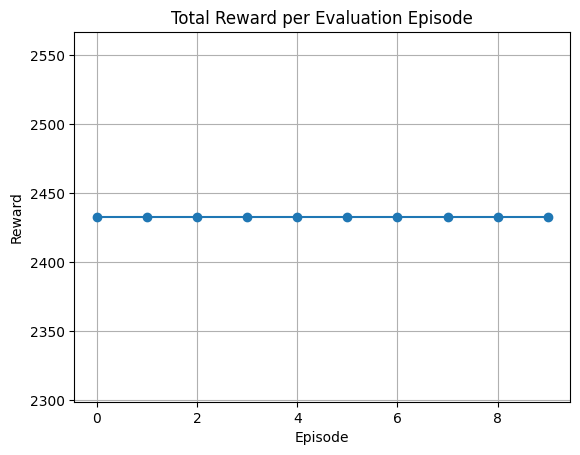

In [40]:
from stable_baselines3 import PPO
import matplotlib.pyplot as plt

def evaluate_model(env, model, num_episodes=10):
    rewards = []
    food_gaps = []
    forest_shares = []
    co2_scores = []

    for ep in range(num_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        episode_food_gap = []
        episode_forest = []
        episode_co2 = []

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward

            episode_food_gap.append(info["food_gap"])
            episode_forest.append(info["forest_share"])
            episode_co2.append(info["co2_reduction"])

        rewards.append(total_reward)
        food_gaps.append(np.mean(episode_food_gap))
        forest_shares.append(np.mean(episode_forest))
        co2_scores.append(np.mean(episode_co2))

    print("📊 Evaluation Summary:")
    print(f"Avg Total Reward over {num_episodes} episodes: {np.mean(rewards):.2f}")
    print(f"Avg Food Gap: {np.mean(food_gaps):.2f}")
    print(f"Avg Forest Share: {np.mean(forest_shares):.2f}")
    print(f"Avg CO2 Reduction: {np.mean(co2_scores):.2f}")

    # Optional: Plot rewards
    plt.plot(rewards, marker='o')
    plt.title("Total Reward per Evaluation Episode")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.grid(True)
    plt.show()

    return rewards

# Run evaluation
evaluation_rewards = evaluate_model(env, model, num_episodes=10)